In [1]:
!pip install torch torchvision torchinfo torchmetrics tqdm

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision,\
                                        MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassConfusionMatrix,\
                                        MulticlassF1Score, MulticlassFBetaScore, MulticlassRecall, MulticlassROC

from sklearn.metrics import classification_report

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

print(torch.__version__)
print(torchvision.__version__)
print(torchmetrics.__version__)

1.11.0
0.12.0
0.10.0


In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    transforms.RandomAffine(degrees=0, scale=(0.5, 1)),
    transforms.RandomAffine(degrees=0, shear=(-10, 10, -10, 10)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215827, 0.44653124], [
                         0.24703233, 0.24348505, 0.26158768])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215827, 0.44653124], [
                         0.24703233, 0.24348505, 0.26158768])
])

In [4]:
cifar_trainset = torchvision.datasets.CIFAR10(
    root='./dataset', train=True, download=True, transform=train_transform)
cifar_testset = torchvision.datasets.CIFAR10(
    root='./dataset', train=False, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset


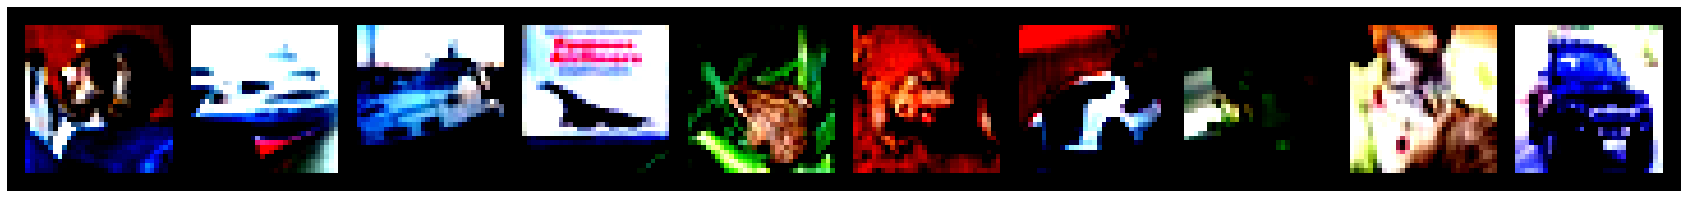

In [5]:
images, labels = zip(*[cifar_testset[i] for i in range(10)])
images = torch.stack(images)

grid = torchvision.utils.make_grid(images, nrow=10, padding=4)

fig, ax = plt.subplots(figsize=(30, 30))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

In [6]:
EPOCHS = 64
BATCH_SIZE = 128
LEARNING_RATE = 0.1
CLASSES = 10
CHANNELS = 3
WIDTH = 32
HEIGHT = 32

In [7]:
train_loader = DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
valid_loader = DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [8]:
class CNN(nn.Module):
    def __init__(self, channels, classes) -> None:
        super(CNN, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(0.1),
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.1),
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.1),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(0.1),
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64 * WIDTH // 4 * HEIGHT // 4, out_features=256),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=256, out_features=classes)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        x = torch.flatten(x, start_dim=1)

        x = self.classifier(x)

        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
model = CNN(CHANNELS, CLASSES).to(device)

In [12]:
summary(model=model, input_size=[BATCH_SIZE, CHANNELS, WIDTH, HEIGHT], device=device, col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"], depth=3)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable                 Kernel Shape
CNN                                      [128, 3, 32, 32]          [128, 10]                 --                        True                      --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 32, 32, 32]         --                        True                      --
│    └─Conv2d: 2-1                       [128, 3, 32, 32]          [128, 32, 32, 32]         864                       True                      [3, 3]
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         [128, 32, 32, 32]         64                        True                      --
│    └─LeakyReLU: 2-3                    [128, 32, 32, 32]         [128, 32, 32, 32]         --                        --                        --
├─Sequential: 1-2                        [128, 32, 32, 32]         [128, 64, 32, 32]         --   

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001, momentum=0.3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=16, gamma=0.1)

In [14]:
train_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassF1Score(num_classes=CLASSES, average=None),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
    # MulticlassConfusionMatrix(num_classes=CLASSES),
    # MulticlassROC(num_classes=CLASSES, thresholds=None)
    # MulticlassPrecisionRecallCurve(num_classes=CLASSES, thresholds=None),
], prefix='train_').to(device)

valid_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassF1Score(num_classes=CLASSES, average=None),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
    # MulticlassConfusionMatrix(num_classes=CLASSES),
    # MulticlassROC(num_classes=CLASSES, thresholds=None)
    # MulticlassPrecisionRecallCurve(num_classes=CLASSES, thresholds=None),
], prefix='val_').to(device)

train_metrics = []
valid_metrics = []

train_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}
valid_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

In [15]:
for epoch in tqdm(range(EPOCHS), desc='Epocs'):
    train_metrics_coll.reset(), valid_metrics_coll.reset()

    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        model.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() # no need to divide, as reduction type is mean by default
        _, prediction = torch.max(outputs.data, 1)

        '''
            Both .forward() and .update() do slightly different things. 
            The .update() method is somewhat simpler: it just updates the metric. 
            In contrast, .forward() updates the metric, 
            but it also lets us report the metric for each individual batch update

            to call forward => train_metrics(outputs, labels)
        '''
        batch_metrics = train_metrics_coll.update(outputs, labels)

    scheduler.step()
  
    train_loss /= len(train_loader)

    model.eval()
    valid_loss = 0.0
    with torch.inference_mode():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)

            batch_metrics = valid_metrics_coll.update(outputs, labels)

            # outputs = F.softmax(outputs, dim=1)
            # _, preds = torch.max(outputs, 1)

            # report = classification_report(preds.cpu().numpy(), labels.cpu().numpy())
            # print(report)

    valid_loss /= len(valid_loader)

    train_metrics.append(train_metrics_coll.compute())
    valid_metrics.append(valid_metrics_coll.compute())

    train_metrics_vals['loss'].append(train_loss)
    valid_metrics_vals['loss'].append(valid_loss)

    if not (epoch + 1) % 10:
        print(f'Epoch: {epoch + 1}')
        print(f'Train Loss: {train_loss}, Train Metrics: {train_metrics_coll.compute()}')
        print(f'Valid Loss: {valid_loss}, Valid Metrics: {valid_metrics_coll.compute()}')
    

Epocs:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 10
Train Loss: 1.1286110592194092, Train Metrics: {'train_MulticlassAccuracy': tensor(0.5974, device='cuda:0'), 'train_MulticlassPrecision': tensor(0.5950, device='cuda:0'), 'train_MulticlassRecall': tensor(0.5974, device='cuda:0'), 'train_MulticlassF1Score': tensor([0.6275, 0.6968, 0.4967, 0.4159, 0.5411, 0.5256, 0.6528, 0.6402, 0.7092,
        0.6543], device='cuda:0'), 'train_MulticlassFBetaScore': tensor(0.5968, device='cuda:0')}
Valid Loss: 0.9545271524900123, Valid Metrics: {'val_MulticlassAccuracy': tensor(0.6567, device='cuda:0'), 'val_MulticlassPrecision': tensor(0.6785, device='cuda:0'), 'val_MulticlassRecall': tensor(0.6567, device='cuda:0'), 'val_MulticlassF1Score': tensor([0.6510, 0.7615, 0.5534, 0.4975, 0.5906, 0.5840, 0.6776, 0.7070, 0.8065,
        0.7384], device='cuda:0'), 'val_MulticlassFBetaScore': tensor(0.6543, device='cuda:0')}
Epoch: 20
Train Loss: 0.8354475404971685, Train Metrics: {'train_MulticlassAccuracy': tensor(0.7065, device='cuda:0'), 'train_Mult

KeyboardInterrupt: 

In [16]:
for key, _ in train_metrics_coll.items():
    print(f'{key}: {train_metrics_coll.compute()[key]}')

train_MulticlassAccuracy: 0.7411542534828186
train_MulticlassPrecision: 0.7402382493019104
train_MulticlassRecall: 0.7408283352851868
train_MulticlassF1Score: tensor([0.7629, 0.8422, 0.6496, 0.5950, 0.7026, 0.6758, 0.7784, 0.7699, 0.8317,
        0.7962], device='cuda:0')
train_MulticlassFBetaScore: 0.7406485676765442


In [17]:
for key, _ in valid_metrics_coll.items():
    print(f'{key}: {valid_metrics_coll.compute()[key]}')

val_MulticlassAccuracy: 0.0
val_MulticlassPrecision: 0.0
val_MulticlassRecall: 0.0
val_MulticlassF1Score: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
val_MulticlassFBetaScore: 0.0


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassF1Score was calle

In [18]:
plt.rcParams["figure.figsize"] = (20, 10)

In [19]:
for metric in train_metrics:
    train_metrics_vals['accuracy'].append(metric['train_MulticlassAccuracy'].cpu())
    train_metrics_vals['precision'].append(metric['train_MulticlassPrecision'].cpu())
    train_metrics_vals['recall'].append(metric['train_MulticlassRecall'].cpu())
    train_metrics_vals['fBetaScore'].append(metric['train_MulticlassFBetaScore'].cpu())

In [20]:
for metric in valid_metrics:
    valid_metrics_vals['accuracy'].append(metric['val_MulticlassAccuracy'].cpu())
    valid_metrics_vals['precision'].append(metric['val_MulticlassPrecision'].cpu())
    valid_metrics_vals['recall'].append(metric['val_MulticlassRecall'].cpu())
    valid_metrics_vals['fBetaScore'].append(metric['val_MulticlassFBetaScore'].cpu())

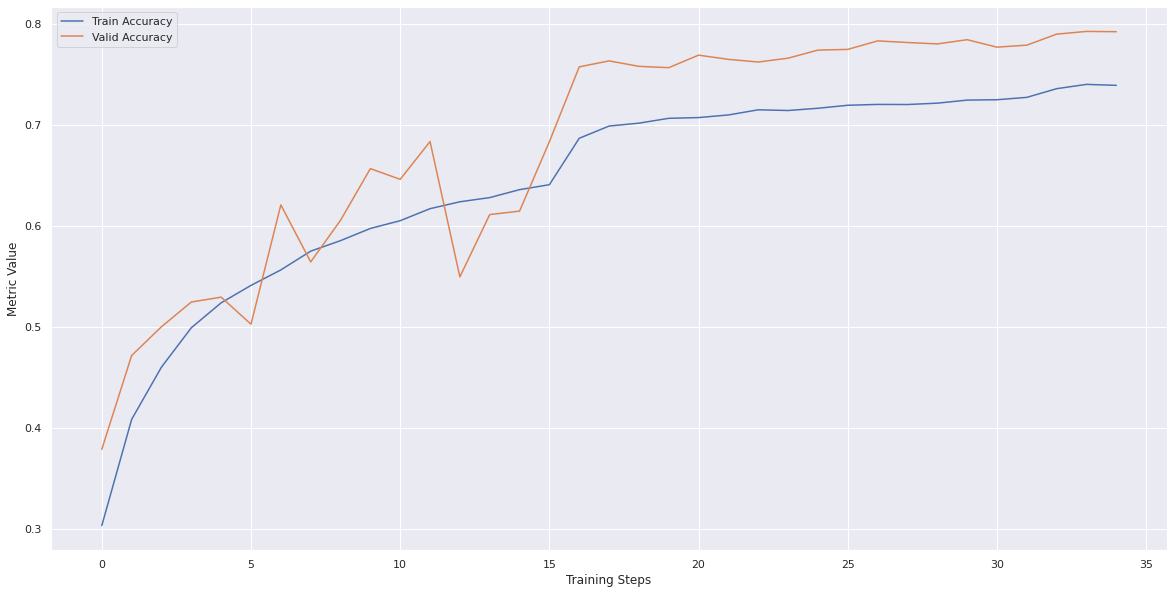

In [21]:
plt.plot(train_metrics_vals['accuracy'], label="Train Accuracy")
plt.plot(valid_metrics_vals['accuracy'], label="Valid Accuracy")

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

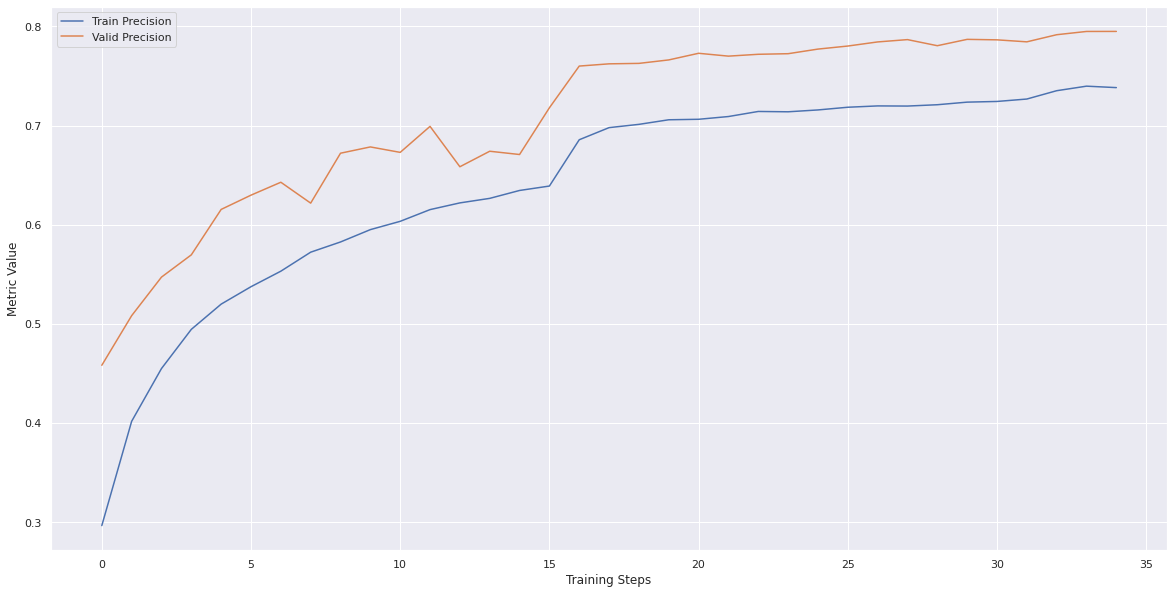

In [22]:
plt.plot(train_metrics_vals['precision'], label="Train Precision")
plt.plot(valid_metrics_vals['precision'], label="Valid Precision")

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

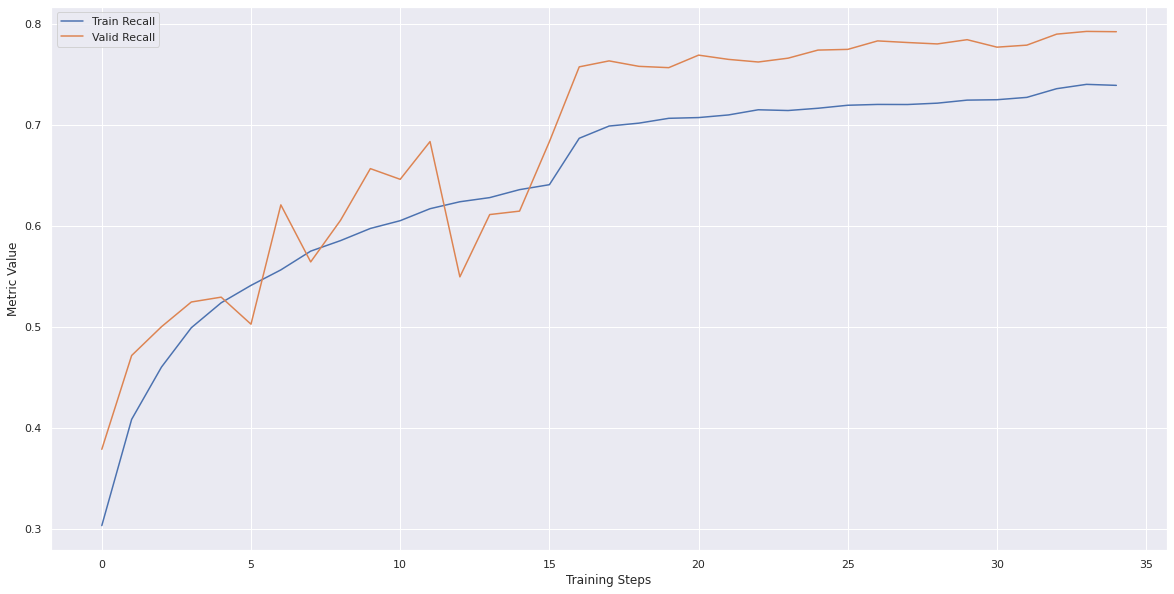

In [23]:
plt.plot(train_metrics_vals['recall'], label="Train Recall")
plt.plot(valid_metrics_vals['recall'], label="Valid Recall")

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

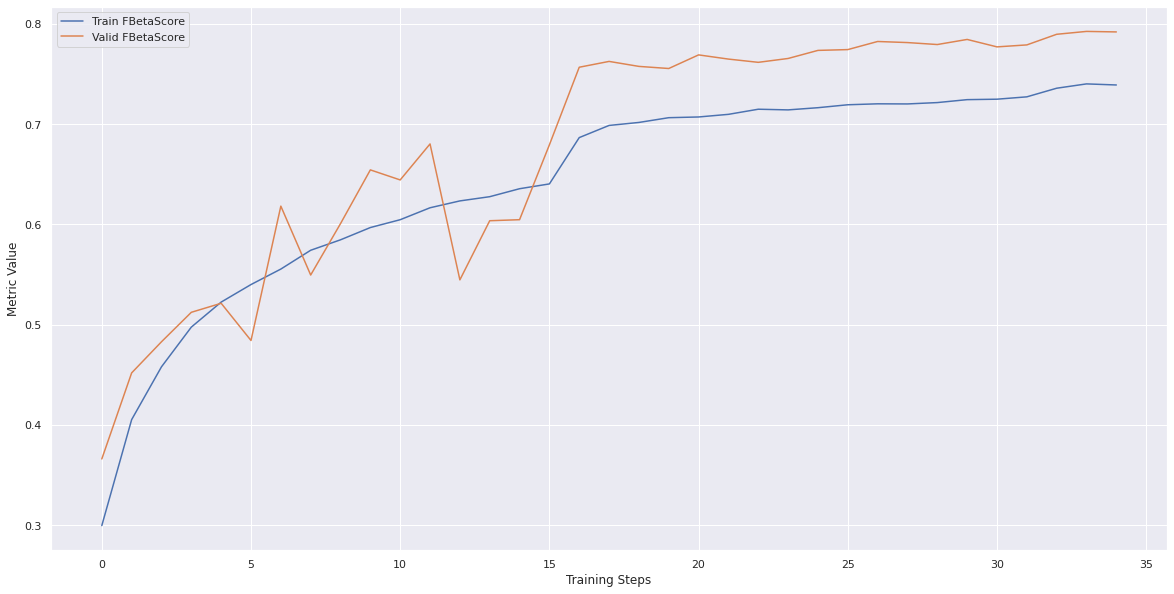

In [24]:
plt.plot(train_metrics_vals['fBetaScore'], label="Train FBetaScore")
plt.plot(valid_metrics_vals['fBetaScore'], label="Valid FBetaScore")

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

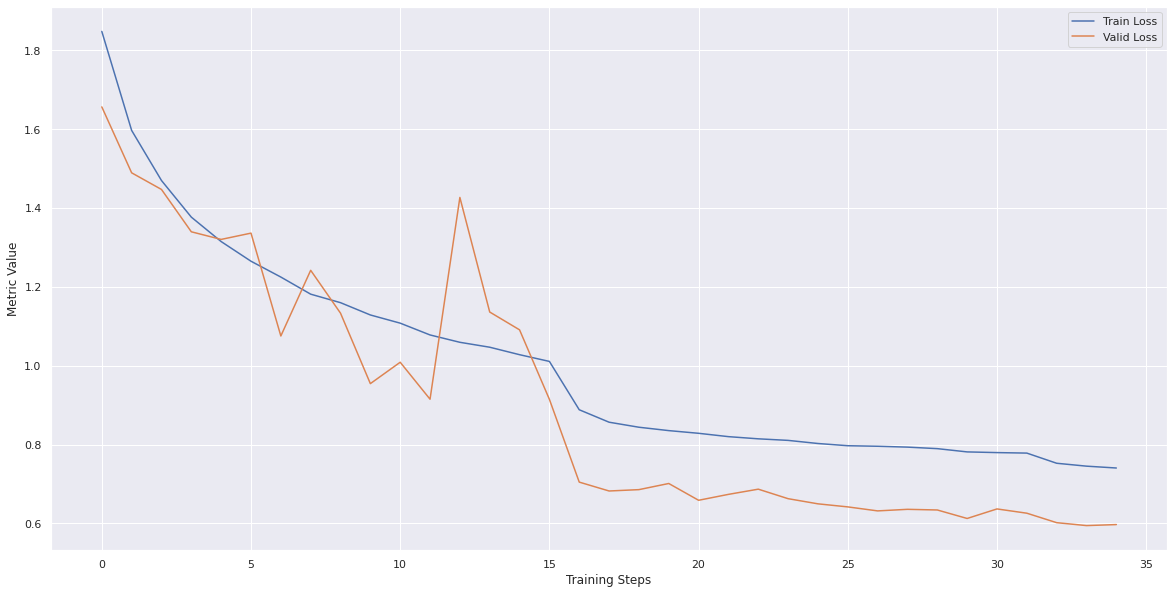

In [25]:
plt.plot(train_metrics_vals['loss'], label="Train Loss")
plt.plot(valid_metrics_vals['loss'], label="Valid Loss")

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

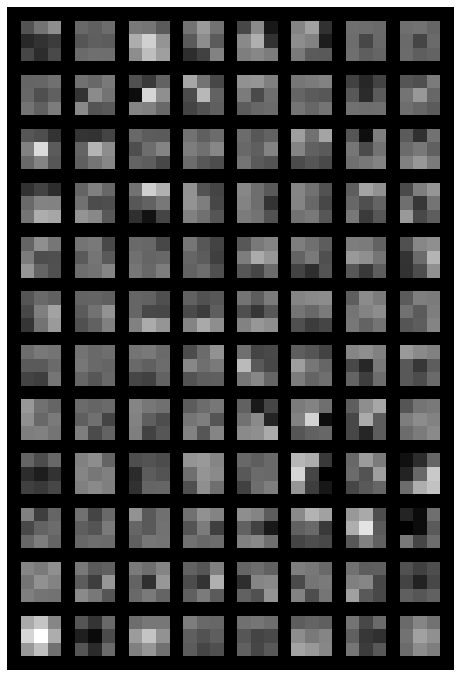

In [26]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='magma')

    plt.axis('off')
    plt.ioff()
    plt.show()


if __name__ == "__main__":
    filter = model.convblock1[0].weight.detach()
    visTensor(filter, ch=0, allkernels=True)